# <span style="color:orange">**Inference**</span>
### Notebook to infer a trained model on data prepared in the notebook `Prepare Complete Dataset`.

---

### 🧠 **Training Data**  
**Period:** *2019-01-01 → 2023-10-31*  
**Size:** ~16,000,000 rows *(undersampled)*

### 🔍 **Inference Data**  
**Period:** *2023-11-01 → 2023-12-31*    
**Size:** ~4,270,000 rows

___
___
# **Librairies**

In [1]:
from utility_script_dynamic_rythms import *

___
___
# **Open Data**

In [2]:
%%time

# Read CSV
df = pd.read_csv(filepath_to_inference_dataset)

# Sort values
df = df.sort_values(by = ['fips', 'date', 'hour']).reset_index(drop=True)

# Show
print(df.shape)
df.head()

(4268242, 144)
CPU times: user 1min 1s, sys: 20.7 s, total: 1min 22s
Wall time: 2min


,fips,date,month,week,dayofweek,hour,outages,outages_outbreak,Proportion_of_fips_within_300km_with_more_than_50_outages,Proportion_of_fips_within_600km_with_more_than_50_outages,...,Biggest_raise_of_outages_over_last_6h,DIFF_outages_from_24hours_ago,Biggest_raise_of_outages_over_last_24h,DIFF_outages_outbreak,DIFF_outages_outbreak_from_6hours_ago,Biggest_raise_of_outages_outbreak_over_last_6h,DIFF_outages_outbreak_from_24hours_ago,Biggest_raise_of_outages_outbreak_over_last_24h,outages_in_6hours,outages_outbreak_in_6hours
0,1001,2023-11-01,11,44.0,2,0,4.0,0,0.01130,0.01572,...,0.0,NaN,0.0,0.0,NaN,0.0,NaN,0.0,0.0,0.0
1,1001,2023-11-01,11,44.0,2,1,5.0,0,0.01695,0.01572,...,0.0,NaN,0.0,0.0,NaN,0.0,NaN,0.0,0.0,0.0
2,1001,2023-11-01,11,44.0,2,2,6.0,0,0.02260,0.02516,...,0.0,NaN,0.0,0.0,NaN,0.0,NaN,0.0,0.0,0.0
3,1001,2023-11-01,11,44.0,2,3,4.0,0,0.02260,0.02202,...,0.0,NaN,0.0,0.0,NaN,0.0,NaN,0.0,0.0,0.0
4,1001,2023-11-01,11,44.0,2,4,0.0,0,0.02260,0.01729,...,0.0,NaN,0.0,0.0,NaN,0.0,NaN,0.0,0.0,0.0


___
___
# **Inference**

In [3]:
%%time

# Target
target = "outages_in_6hours"

# Set fips and state as categories
for k in ['state', 'fips']:
    df[k] = df[k].astype('category')

# Load model
model = joblib.load(filepath_trained_model)

# Get model features
feats = model.feature_name_

# Compute predictions
df["preds"] = np.clip(model.predict(df[feats]), 0, None)

# Put back types
for k in ['state', 'fips']:
    df[k] = df[k].astype(dtypes[k])

CPU times: user 1min 59s, sys: 3.37 s, total: 2min 3s
Wall time: 37.1 s


___
___
# **Performance Evaluation**
-  **2 custom metrics** have been designed to evaluate model performance on rare events such as massive outages peaks.
-  These metrics are **more relevant than standard ones**, especially `Mean Absolute Error (MAE)`, which tends to push the model toward forecasting very low outage values. In fact, predicting only zeros is a surprisingly strong baseline for optimizing MAE!
-  However, the best results were obtained by training on `RMSE` rather than on either of the two custom metrics. This can be explained by the fact that LightGBM is optimized for RMSE, whereas our custom metrics are non-differentiable (and non-convex).
-  **<u>Custom metric n°1:</u>**
    - `custom_metric`
    - A variant of RMSE with two modifications: it under-penalizes overestimations a few hours before peaks and over-penalizes underestimations during peaks.
    - The idea is that forecasting major outages a few hours too early is less problematic than predicting them a few hours too late.
-  **<u>Custom metric n°2:</u>**
    - `custom_peak_Fbeta_score`
    - An **Fβ-score** with β=2 (**favoring Recall**). This metric evaluates whether predictions correctly identify major outage outbreaks occurring within the period [current_hour + 4 hours, current_hour + 12 hours].
    - It balances **Recall** (important because missing an outbreak is very costly) and **Precision** (important because false alarms are also costly).

___
## **MAE, RMSE and Custom metric**

<u>Custom Metric:</u>
- A variant of RMSE.
- Under-penalizes overestimations a few hours before peaks and over-penalizes underestimations during peaks.
- The idea is that forecasting major outages a few hours too early is less problematic than predicting them a few hours too late.

In [4]:
mask = (~df[target].isna())

# Store error
gradient = custom_objective(df.loc[mask, target], df.loc[mask, "preds"])[0]
df.loc[mask, 'error'] = np.sqrt(gradient*2)

# Prediction Performance
mae_score    = round(mean_absolute_error(df.loc[mask, target], df.loc[mask, "preds"]), 1)
rmse_score   = round(np.sqrt(mean_squared_error(df.loc[mask, target], df.loc[mask, "preds"])), 1)
custom_score = round(custom_score_function(df.loc[mask, target], df.loc[mask, "preds"]), 1)
print("\nModel Performance:")
print(f"> MAE: {str(mae_score).ljust(5)} // RMSE: {str(rmse_score).ljust(5)} // CUSTOM METRIC: {str(custom_score).ljust(5)}.")

# Predict only zeros (strong baseline for MAE)
all_zeros = np.zeros(len(df[mask]))
mae_score    = round(mean_absolute_error(df.loc[mask, target], all_zeros), 1)
rmse_score   = round(np.sqrt(mean_squared_error(df.loc[mask, target], all_zeros)), 1)
custom_score = round(custom_score_function(df.loc[mask, target], all_zeros), 1)
print("\nPredicting only zeros:")
print(f"> MAE: {str(mae_score).ljust(5)} // RMSE: {str(rmse_score).ljust(5)} // CUSTOM METRIC: {str(custom_score).ljust(5)}.")


Model Performance:
> MAE: 34.9  // RMSE: 317.1 // CUSTOM METRIC: 563.2.

Predicting only zeros:
> MAE: 28.4  // RMSE: 562.7 // CUSTOM METRIC: 1125.4.


___
## **Custom Fβ-score**

<u>Goal:</u> Evaluate how well the predictions detect major outages happening soon (lead-time from 4 to 12 hours ahead).

- A **true outage outbreak** is defined as ≥100 outages and ≥0.1% of the county's population.
- A prediction "finds" an outbreak if it covers at least **100 outages** AND **at least 50% of the true number of outages**.
  
**<u>Metrics:</u>**
- Precision: Proportion of predicted outbreaks that were correct.
- Recall: Proportion of true outbreaks that were successfully predicted.
- fβ _score: Weighted Fβ-score balancing precision and recall according to beta (β > 1 favors Recall, β < 1 favors Precision).

### **Performance on Moderate outages outbreaks detection**
At least **100** outbreaks.

In [5]:
# Evaluate how well the predictions detect major outages happening soon (lead-time from 4 to 12 hours ahead)
precision, recall, fbeta_score = custom_peak_Fbeta_score(df,
                                                         target_col="outages_in_6hours",
                                                         pred_col="preds",
                                                         thr_outages=100,
                                                         beta=2,
                                                         display_result=True,
                                                        )

PRECISION: 34.2%.
-> Among predicted outage outbreaks, 34.2% are correct.
   -> Important metric if false alarms are costly.

RECALL: 47.0%.
-> We find 47.0% of true outage outbreaks (4 to 12 hours ahead).
   -> Important metric if missing an outbreak is costly.

Fβ-score: 43.7%.
-> β=2, favors Recall.


### **Performance on Massive outages outbreaks detection**
At least **3000** outbreaks.

In [6]:
# Evaluate how well the predictions detect major outages happening soon (lead-time from 4 to 12 hours ahead)
precision, recall, fbeta_score = custom_peak_Fbeta_score(df,
                                                         target_col="outages_in_6hours",
                                                         pred_col="preds",
                                                         thr_outages=3000,
                                                         beta=2,
                                                         display_result=True,
                                                        )

PRECISION: 75.4%.
-> Among predicted outage outbreaks, 75.4% are correct.
   -> Important metric if false alarms are costly.

RECALL: 22.2%.
-> We find 22.2% of true outage outbreaks (4 to 12 hours ahead).
   -> Important metric if missing an outbreak is costly.

Fβ-score: 25.9%.
-> β=2, favors Recall.


### **Plot model performance for varying outages tresholds**
With the graph below, we see that **the larger the predicted peak, the more meaningful the prediction.**<br>
Indeed, massive outbreaks (e.g., from catastrophic weather events) are easier to predict than small, localized ones.

**<u>Recall</u>**
- ~30% of peaks with >4000 outages were correctly predicted by our model a few hours earlier.

**<u>Precision</u>**
- Predicted high peaks are **very reliable**:
    - 90% of predicted peaks of more than 6000 outages will indeed happen in the next few hours.

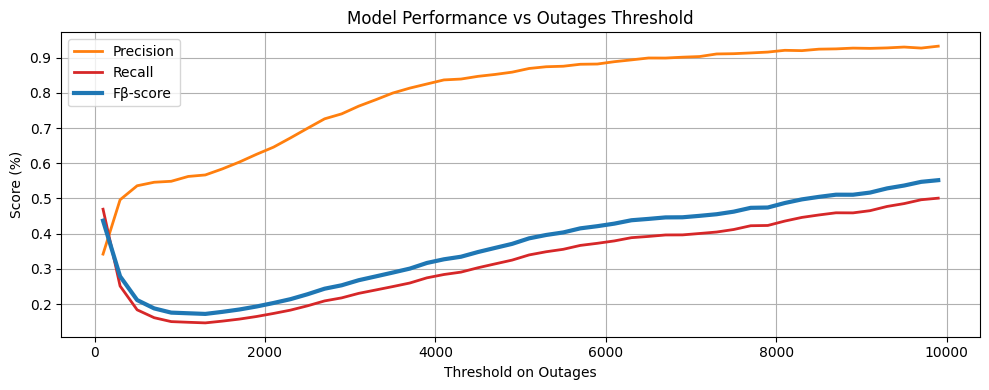

In [7]:
# Plot model performance for varying outages tresholds
plot_fbeta_curve(df)

___
___
# **Plot Mean Custom Errors on a map**
- At county and state levels.

## **Observations :**
- Errors are unevenly distributed across counties and states. **Higher population density tends to correlate with larger prediction errors.**
- Also, counties with large surface areas are also harder to predict, as the neighboring-county grid becomes less effective.
- Finally, the distribution of errors varies depending on the time period analyzed. Periods with fewer outages naturally result in lower overall errors.

### **Custom error**
Custom variant of Asymmetric mean absolute error. <br>
2 differences :
- Under-penalize over-estimations some hours ahead of peaks by 100%.
- Over-penalize under-estimations errors on peaks (outages > thr) by 100%.

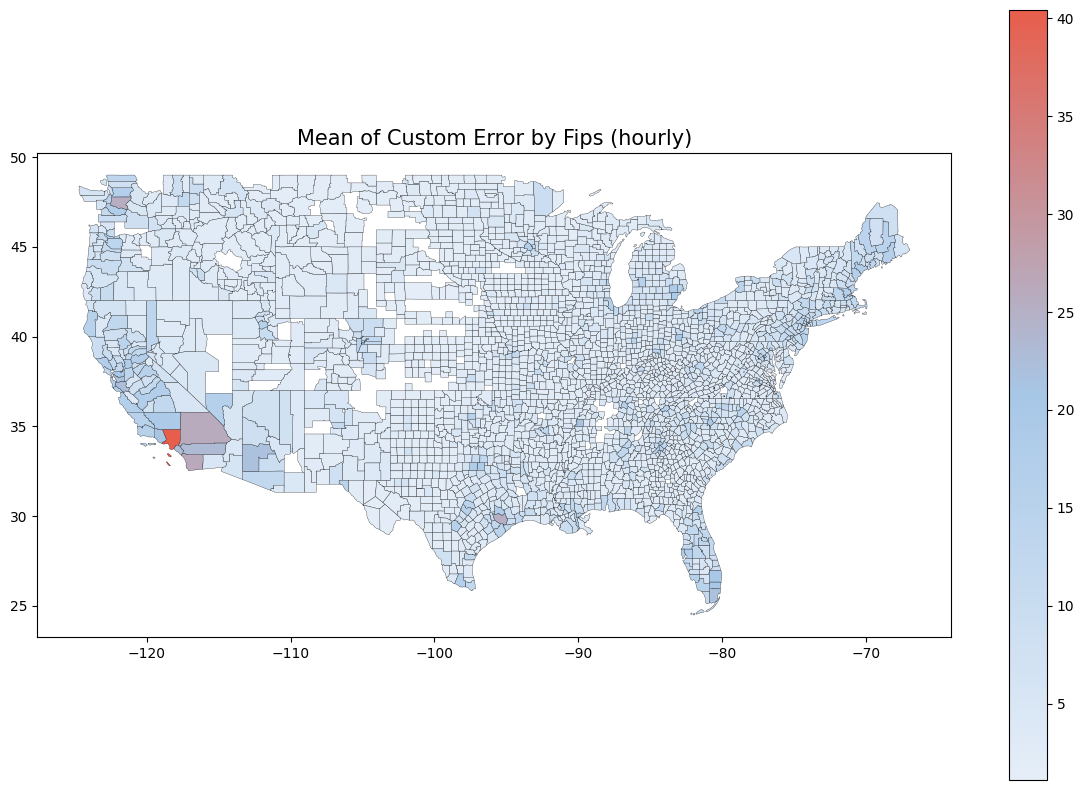

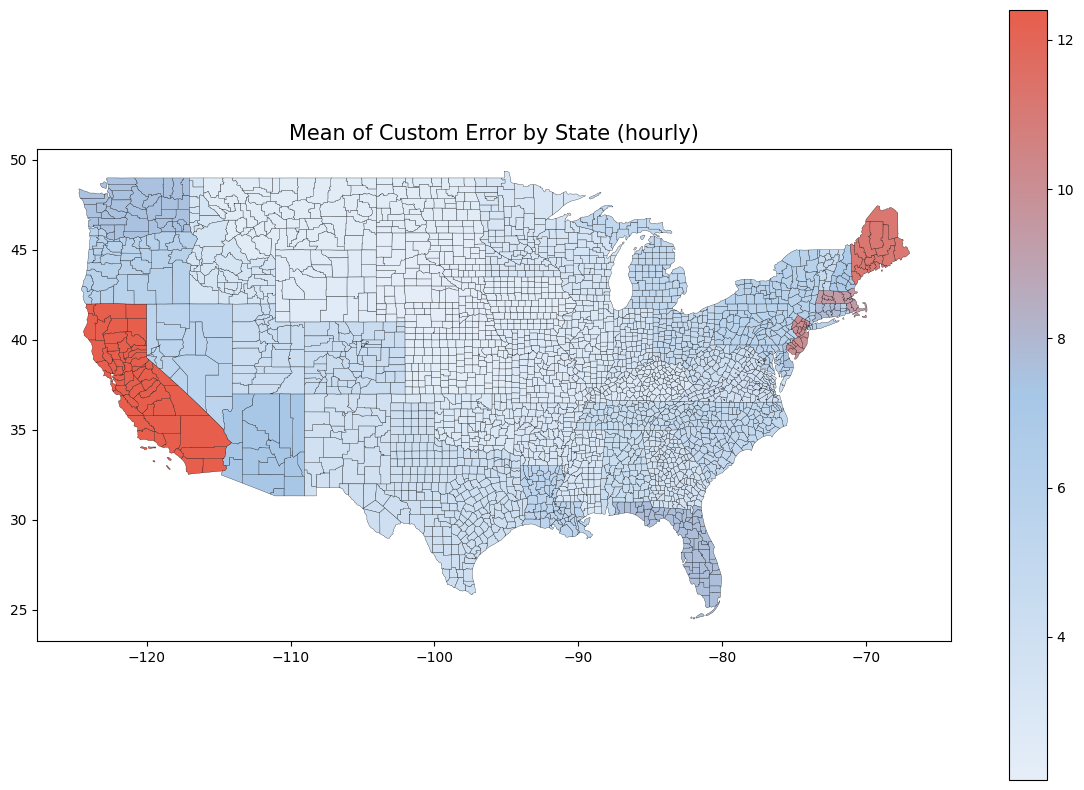

In [8]:
# Compute error
gradient = custom_objective(df.loc[mask, target], df.loc[mask, "preds"])[0]
df.loc[mask, 'error'] = np.sqrt(gradient*2)

# Plot graph at fips level
stats = df.groupby('fips')['error'].mean().to_frame().reset_index()
plot_fips_on_map(stats,
                 color_col='error',
                 title = 'Mean of Custom Error by Fips (hourly)',
                 cmap=custom_cmap,
                )

# Plot graph at state level
stats = df.groupby('state')['error'].mean().to_frame().reset_index()
plot_state_on_map(stats,
                  color_col='error',
                  title = 'Mean of Custom Error by State (hourly)',
                  cmap=custom_cmap,
                 )

___
___
# **Show Predictions**

___
## **Predictions of Massive Power Outages Following Storms in December 2023 on the Northeast Coast**
> The storms hit around December 17th to 19th.
> 
> Article about the event: https://www.ctpublic.org/news/2023-12-18/storm-hits-connecticut-with-strong-winds-heavy-rain-power-outages

#### **Kentucky - Mason County** (fips 1073).
> **<span style="color:#42D674;">Outage prediction right on time.</span><br>**
> **<span style="color:#c54f4d;">Underestimated number of outages.</span><br>**
> **<span style="color:#42D674;">Great estimated duration of outages.</span>**

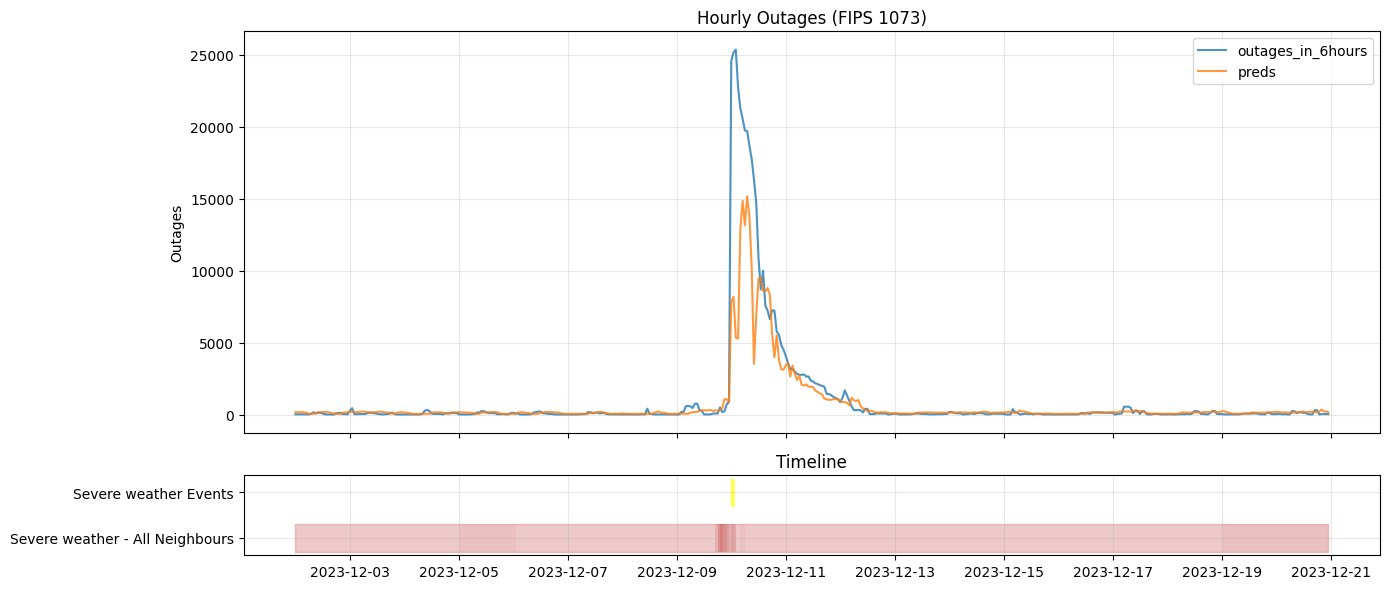

In [9]:
# Plot predictions fips 1073 (Mason County - Kentucky)
plot_peaks(df,
           fips=1073,
           cols_to_plot=[target, 'preds'],
           cols_timeline = ['Severe_events_count', 'Severe_events_count_sum_among_ALL_neighbours'],
           start_date='2023-12-02',
           end_date='2023-12-20',
           plot_timeline_with_intensity = True,
           )

#### **Maine - Cumberland County** (fips 23005).
> **<span style="color:#42D674;">Outage prediction right on time.</span><br>**
> **<span style="color:#42D674;">Perfect estimated number of outages.</span><br>**
> **<span style="color:#42D674;">Perfect estimated duration of outages.</span>**

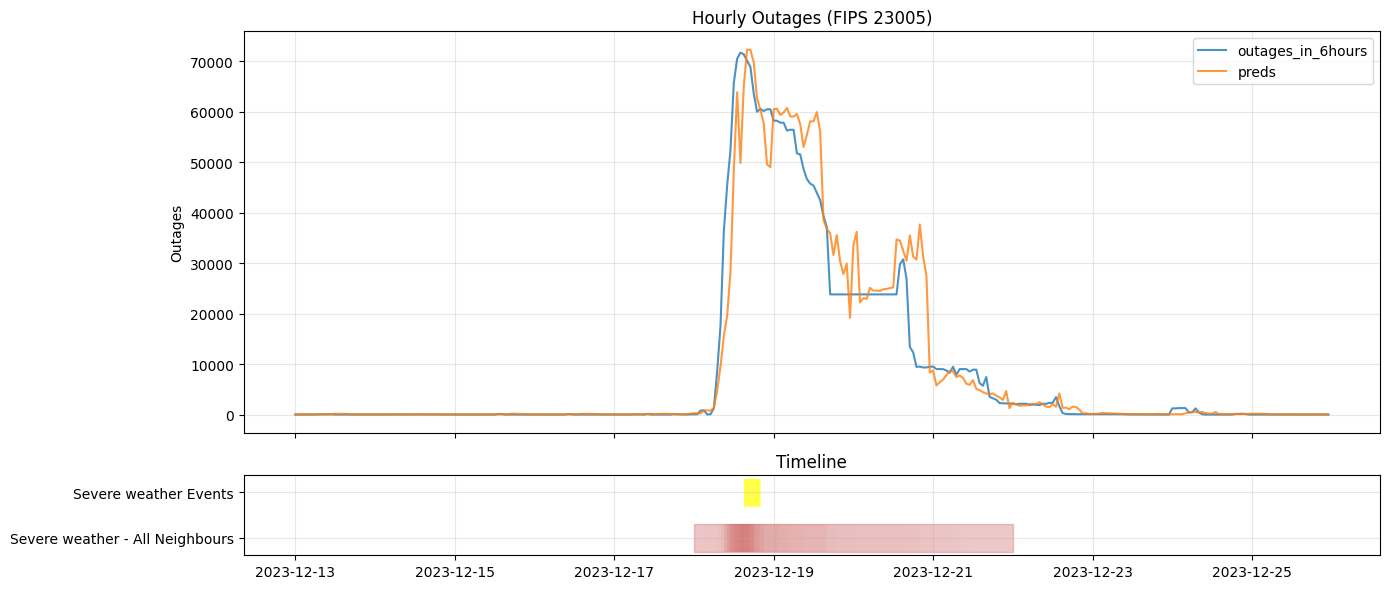

In [10]:
# Plot predictions fips 23005 (Cumberland County - Maine)
plot_peaks(df,
           fips=23005,
           cols_to_plot=[target, 'preds'],
           cols_timeline = ['Severe_events_count', 'Severe_events_count_sum_among_ALL_neighbours'],
           start_date='2023-12-13',
           end_date='2023-12-25',
           plot_timeline_with_intensity = True,
           )

#### **Maine - Hancock County** (fips 23009).
> **<span style="color:#42D674;">Predictions right on time.</span><br>**
> **<span style="color:#42D674;">Great estimated number of outages.</span><br>**
> **<span style="color:#42D674;">Perfect estimated duration of outages.</span>**

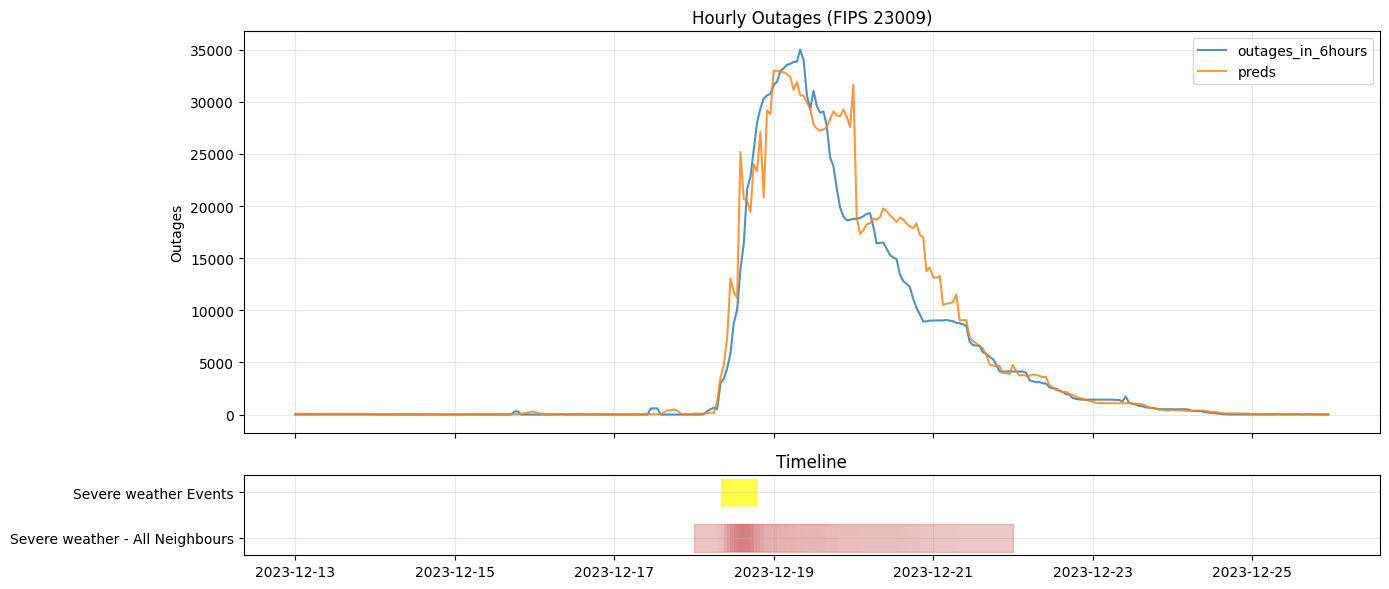

In [11]:
# Plot predictions fips 23009 (Hancock County - Maine)
plot_peaks(df,
           fips=23009,
           cols_to_plot=[target, 'preds'],
           cols_timeline = ['Severe_events_count', 'Severe_events_count_sum_among_ALL_neighbours'],
           start_date='2023-12-13',
           end_date='2023-12-25',
           plot_timeline_with_intensity = True,
           )

#### **Maine - Kennebec County** (fips 23011).
> **<span style="color:#c54f4d;">Late outage predictions.</span><br>**
> **<span style="color:#c54f4d;">Underestimated number of outages.</span><br>**
> **<span style="color:#42D674;">Perfect estimated duration of outages.</span>**

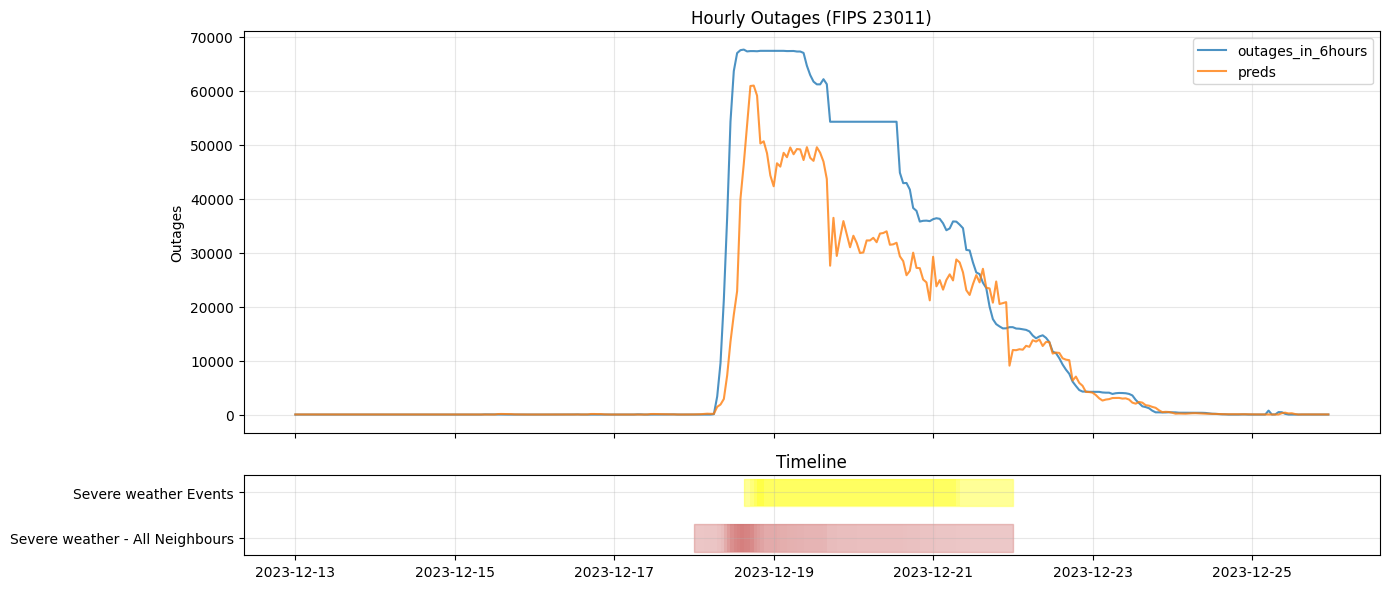

In [12]:
# Plot predictions fips 23011 (Kennebec County - Maine)
plot_peaks(df,
           fips=23011,
           cols_to_plot=[target, 'preds'],
           cols_timeline = ['Severe_events_count', 'Severe_events_count_sum_among_ALL_neighbours'],
           start_date='2023-12-13',
           end_date='2023-12-25',
           plot_timeline_with_intensity = True,
           )

#### **Maine - Penobscot County** (fips 23019).
> **<span style="color:#42D674;">Outage prediction right on time.</span><br>**
> **<span style="color:#c54f4d;">Underestimated number of outages.</span><br>**
> **<span style="color:#42D674;">Perfect estimated duration of outages.</span>**

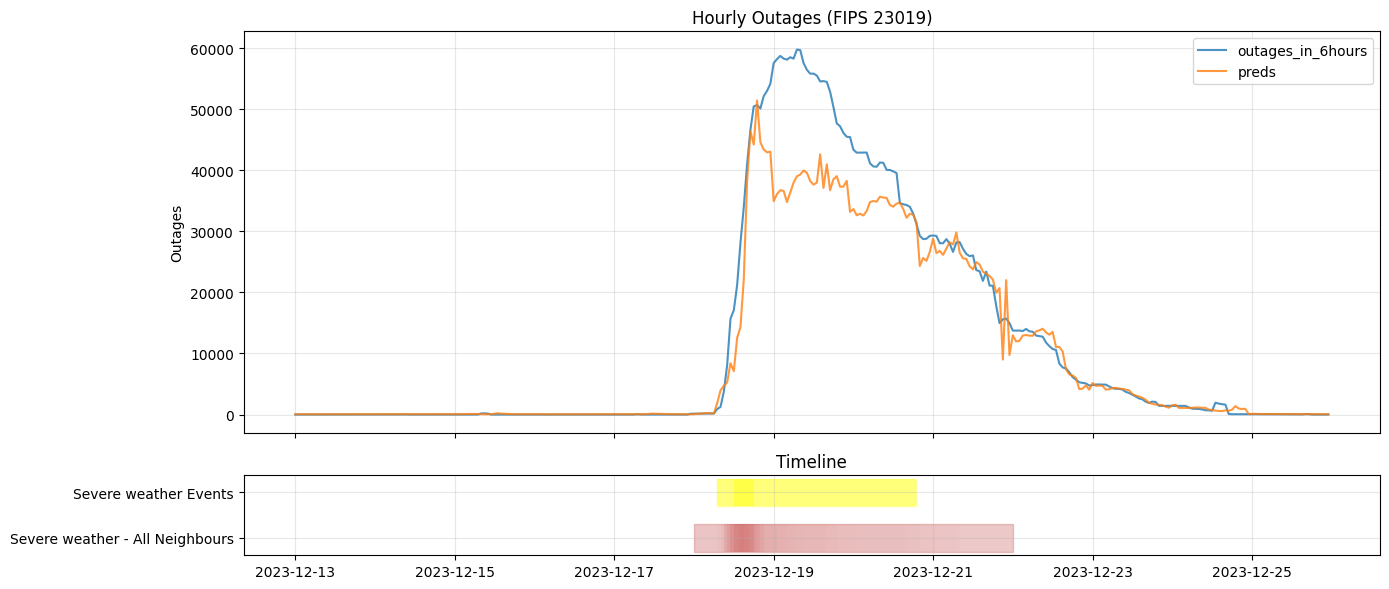

In [13]:
# Plot predictions fips 23019 (Penobscot County - Maine)
plot_peaks(df,
           fips=23019,
           cols_to_plot=[target, 'preds'],
           cols_timeline = ['Severe_events_count', 'Severe_events_count_sum_among_ALL_neighbours'],
           start_date='2023-12-13',
           end_date='2023-12-25',
           plot_timeline_with_intensity = True,
           )

#### **Georgia - Richmond County** (fips 36083).
> **<span style="color:#42D674;">Outage prediction right on time.</span><br>**
> **<span style="color:#42D674;">Great estimated number of outages.</span><br>**
> **<span style="color:#42D674;">Great estimated duration of outages.</span>**

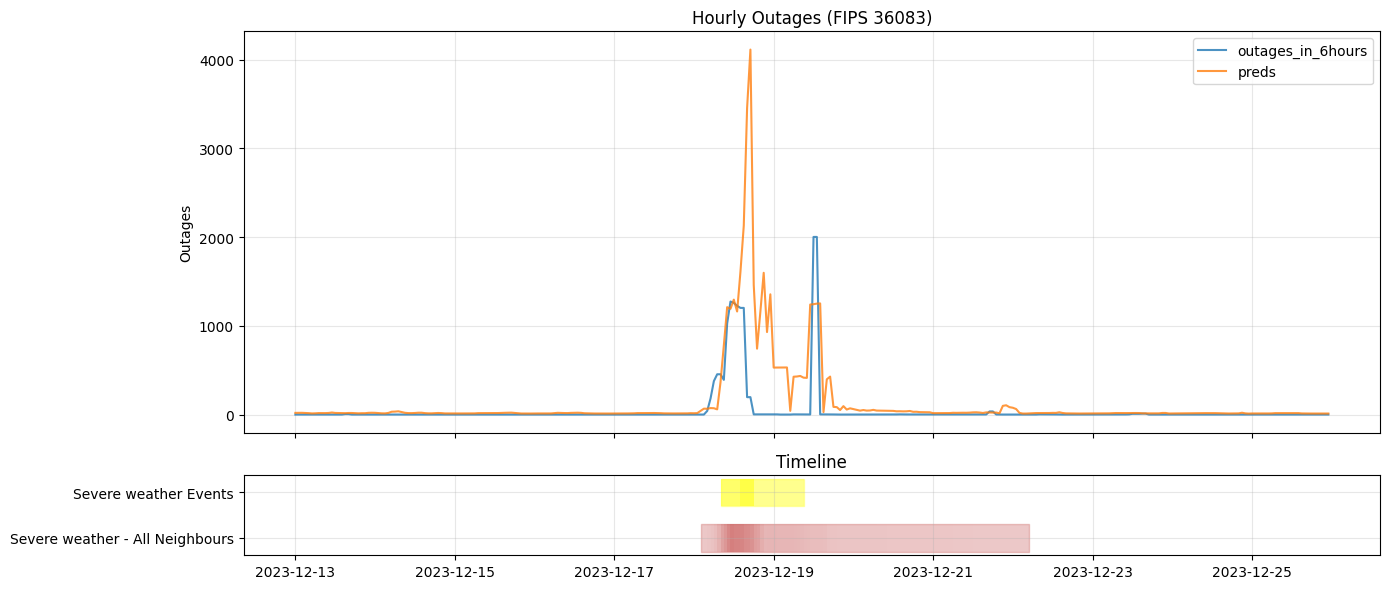

In [14]:
# Plot predictions fips 36083 (Richmond County - Georgia)
plot_peaks(df,
           fips=36083,
           cols_to_plot=[target, 'preds'],
           cols_timeline = ['Severe_events_count', 'Severe_events_count_sum_among_ALL_neighbours'],
           start_date='2023-12-13',
           end_date='2023-12-25',
           plot_timeline_with_intensity = True,
           )

#### **New-York - Suffolk County** (fips 36103).
> **<span style="color:#c54f4d;">Slightly lLate outage predictions.</span><br>**
> **<span style="color:#42D674;">Great estimated number of outages.</span><br>**
> **<span style="color:#42D674;">Great estimated duration of outages.</span>**

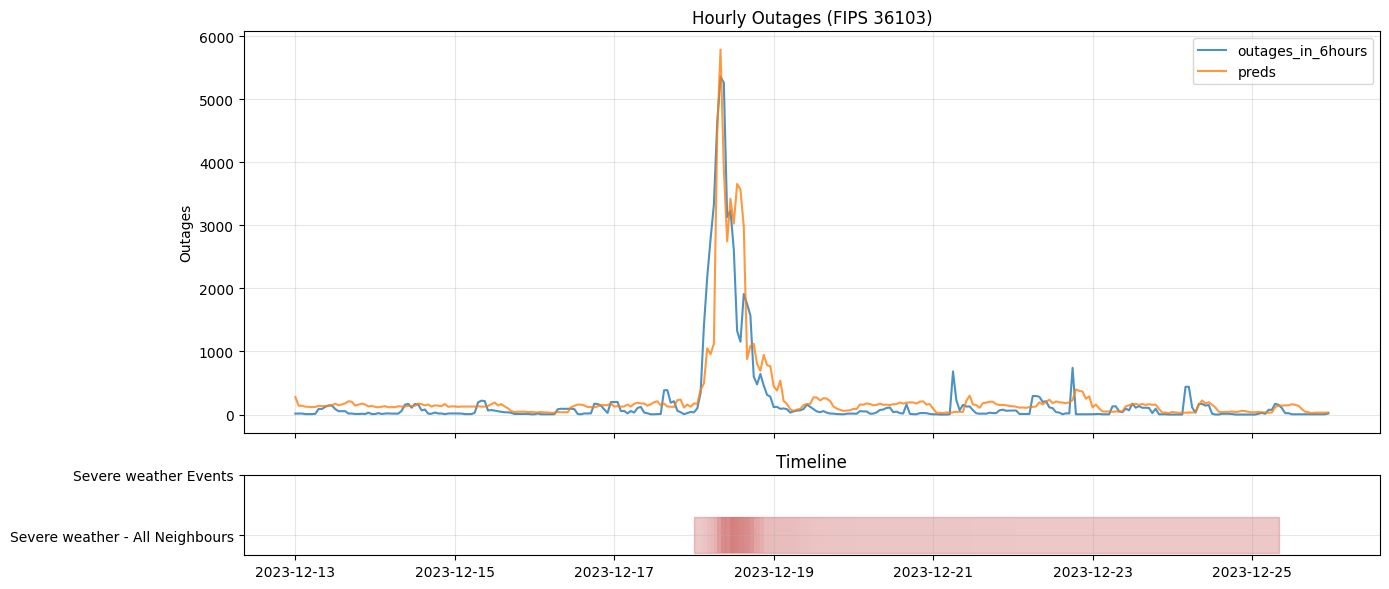

In [15]:
# Plot predictions fips 36103 (Suffolk County - New-York)
plot_peaks(df,
           fips=36103,
           cols_to_plot=[target, 'preds'],
           cols_timeline = ['Severe_events_count', 'Severe_events_count_sum_among_ALL_neighbours'],
           start_date='2023-12-13',
           end_date='2023-12-25',
           plot_timeline_with_intensity = True,
           )

#### **New-York - Ulster County** (fips 36111).
> **<span style="color:#42D674;">Outage prediction right on time.</span><br>**
> **<span style="color:#c54f4d;">Overestimated number of outages.</span><br>**
> **<span style="color:#c54f4d;">Overestimated duration of outages.</span>**

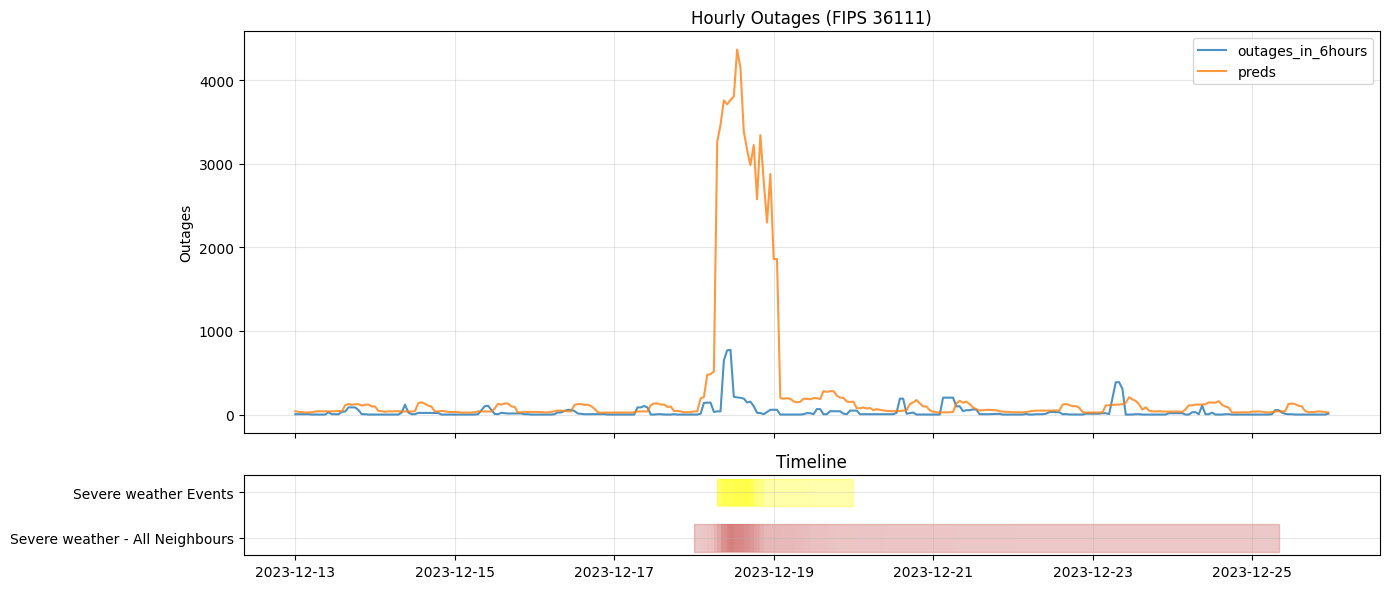

In [16]:
# Plot predictions fips 36111 (Ulster County - New-York)
plot_peaks(df,
           fips=36111,
           cols_to_plot=[target, 'preds'],
           cols_timeline = ['Severe_events_count', 'Severe_events_count_sum_among_ALL_neighbours'],
           start_date='2023-12-13',
           end_date='2023-12-25',
           plot_timeline_with_intensity = True,
           )

#### **Tennessee - Davidson County** (fips 47037).
> **<span style="color:#42D674;">Outage prediction right on time.</span><br>**
> **<span style="color:#c54f4d;">Underestimated initial number of outages.</span><br>**
> **<span style="color:#42D674;">Great estimated duration of outages.</span>**

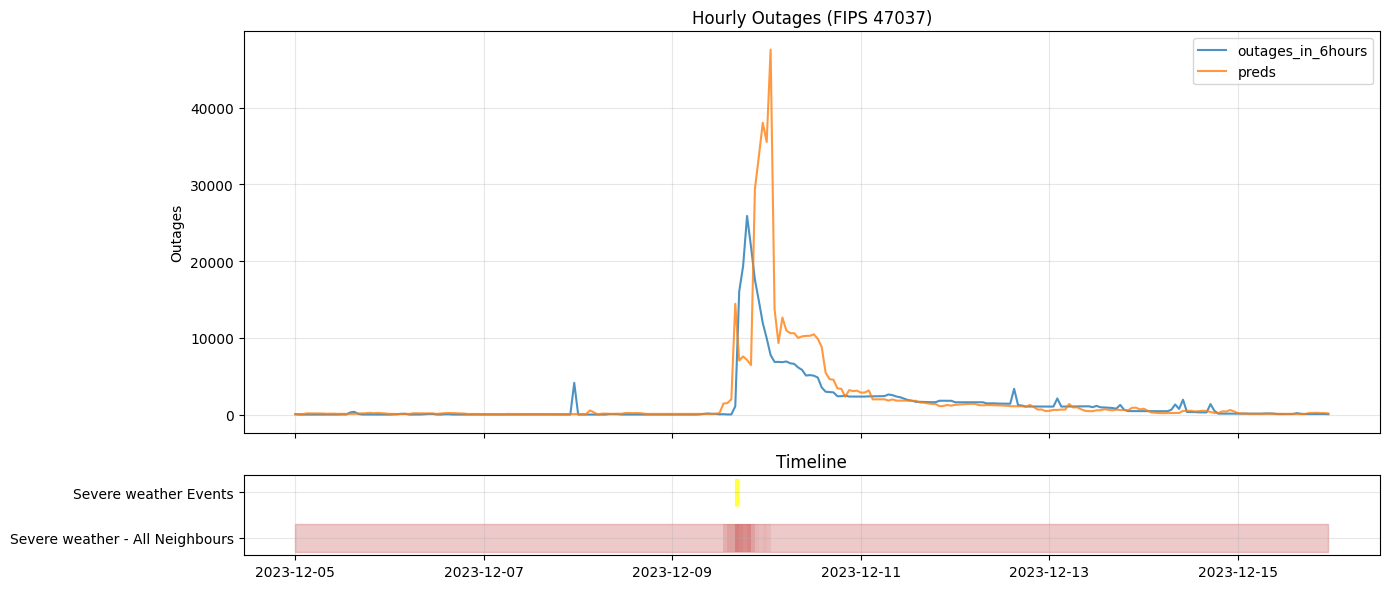

In [17]:
# Plot predictions fips 47037 (Davidson County - Tennessee)
plot_peaks(df,
           fips=47037,
           cols_to_plot=[target, 'preds'],
           cols_timeline = ['Severe_events_count', 'Severe_events_count_sum_among_ALL_neighbours'],
           start_date='2023-12-05',
           end_date='2023-12-15',
           plot_timeline_with_intensity = True,
           )

___
## **Some predictions are hard to make, like in Los Angeles**
> Outages are very frequent and volatiles, with high peaks that do not least very long.

#### **California - Los Angeles County** (fips 23011).

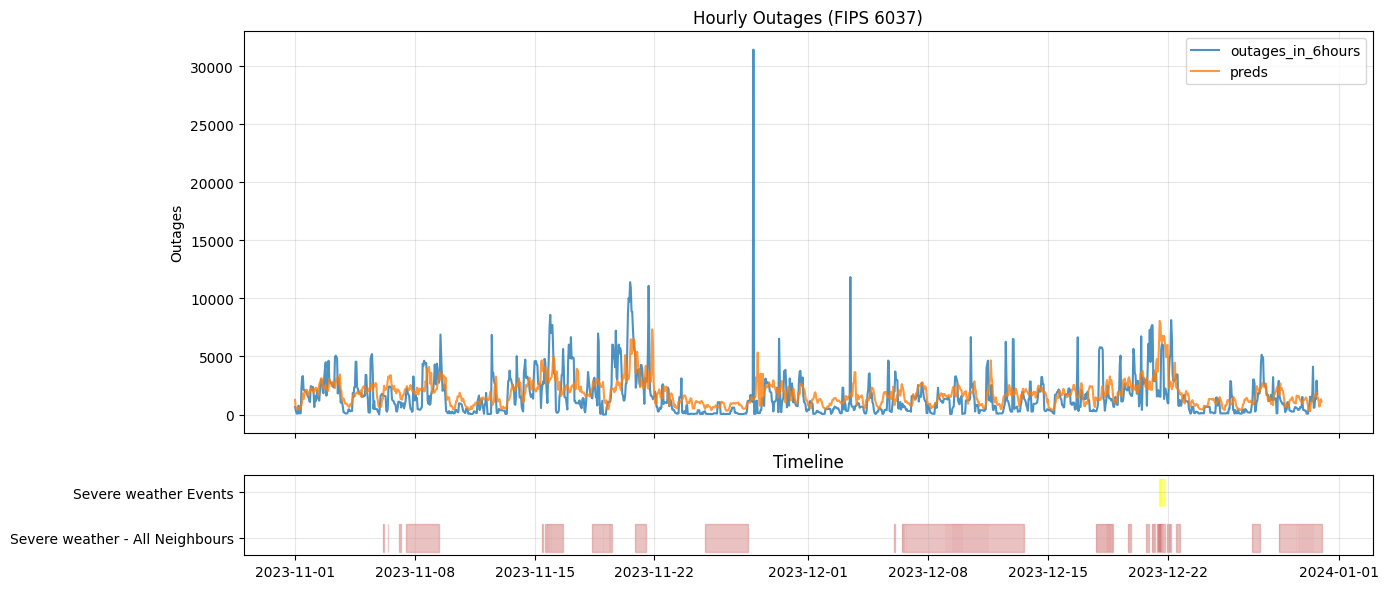

In [18]:
# Plot predictions fips 6037 (Los Angeles County - California)
plot_peaks(df,
           fips=6037,
           cols_to_plot=[target, 'preds'],
           cols_timeline = ['Severe_events_count',
                            'Severe_events_count_sum_among_ALL_neighbours',],
           start_date='2023-11-01',
           end_date='2023-12-31',
           plot_timeline_with_intensity = True,
           figsize=(14, 5),
           )

___
## **Massive Outages Outbreak in Florida - November 2023**

#### **Florida - Miami-Dade County** (fips 12086).
> **<span style="color:#c54f4d;">Late outage predictions.</span><br>**
> **<span style="color:#c54f4d;">Underestimated number of outages.</span><br>**
> **<span style="color:#42D674;">Great estimated duration of outages.</span>**

- The model predicted that the outages would increase more slowly and to a lesser extent, despite severe events being reported in the surrounding area.

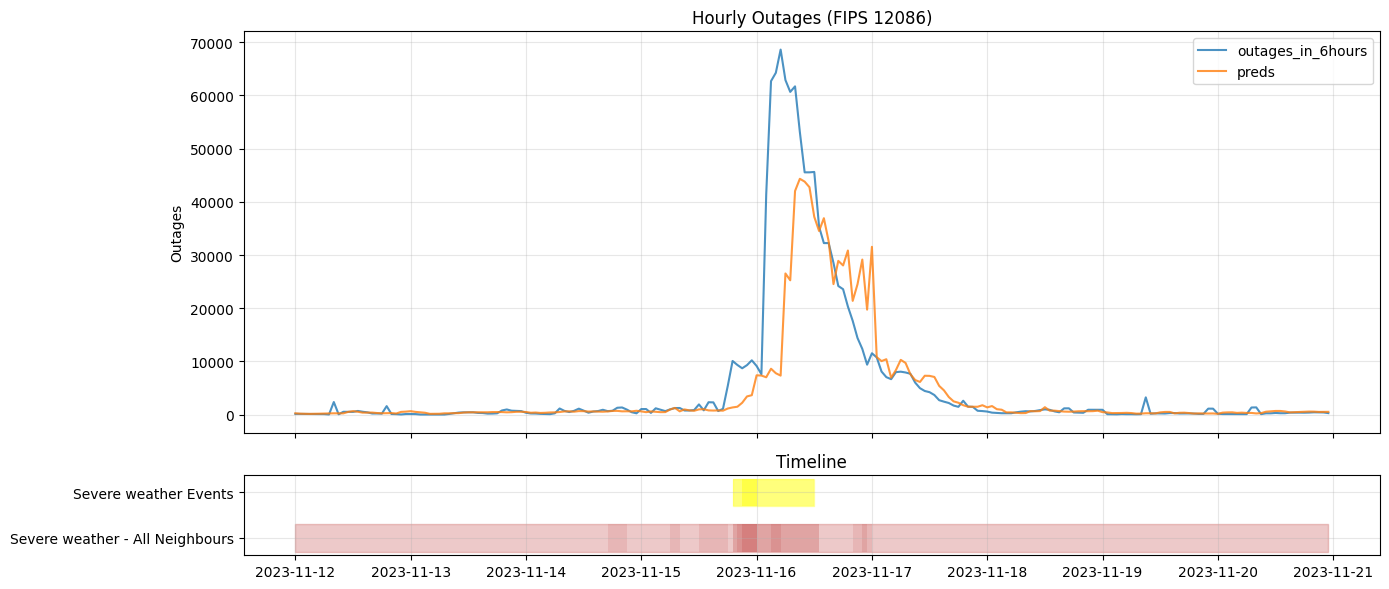

In [19]:
# Plot predictions fips 12086 (Miami-Dade County - Florida)
plot_peaks(df,
           fips=12086,
           cols_to_plot=[target, 'preds'],
           cols_timeline = ['Severe_events_count', 'Severe_events_count_sum_among_ALL_neighbours'],
           start_date='2023-11-12',
           end_date='2023-11-20',
           plot_timeline_with_intensity = True,
           figsize=(14, 5),
           )

___
___
# **Conclusion**

### <u>Objective:</u> Predict the likelihood and severity of power outages at the county level, 6 hours in advance.

### Results
- **2 custom metrics** were developed to select the best features and improve the forecasting model. These metrics were particularly useful for evaluating performance on rare events.
- **We observed that the larger the predicted outage, the more reliable the forecast tends to be..**
- Errors are unevenly distributed across states and counties. Higher population density tends to correlate with larger prediction errors.
- Also, counties with large surface areas are also harder to predict, as the neighboring-county grid becomes less effective.
- <u>**Recall:**</u> Approximately 30% of peaks with over 4,000 outages were correctly predicted several hours in advance.
- <u>**Precision:**</u> 90% of predicted peaks involving more than 6,000 outages did indeed occur within the following few hours.

### Most important features
- `fips code`
- `County Population`
- `Temperature` and `Wind Speed` of past days (external data)
- `Weather events` of past hours (Storms Data), for the current fips and its neighbourhood (1st to 4th adjacency-degree)
- `outages` and `outages outbreak` information (raw values, biggest raise over the last hours)
- Information in state and the neighbourhood (1st to 4th adjacency-degree): `outages sum` , `proportion of counties with more than 50 outages`
- `Project impact of outages waves in 6 hour` (estimated localisation and impact)
- `Keywords from past weather events narratives`. These features have a small forecasting value but they were interesting to use (this isn't typical).

### What could be done next
- The most impactful next step would probably be to incorporate weather forecasts. I considered adding "severe weather events" from future rows (e.g., 24 hours ahead), but avoided it to prevent data leakage — such information would have been unrealistically accurate compared to real forecasts. An alternative would be to generate our own weather forecasts. Just as we modeled the direction and impact of outage waves, we could attempt to estimate the trajectory and severity of upcoming severe weather events.
- Add features relative to the severity of weather events (wind magnitudes were a good start, but not enough). This would help the model know when weather events in the neighbourhood would lead to sudden outages, and when they would not.